<a href="https://colab.research.google.com/github/Vidi005/Klasifikasi-Game-Suit-Gunting-Kertas-Batu/blob/master/Submission_Machine_Learning_Pemula_Dicoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Tangan Membentuk Gunting, Kertas, dan Batu

Program untuk mengenali bentuk jari tangan yang membentuk gunting, kertas, atau batu.
<br>
Program ini dibuat menggunakan CNN dengan library Keras dan backend TensorFlow.


## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.io import imread
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime

%load_ext autotime

Using TensorFlow backend.


  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=135583659dbe5e36100276df7c03d2a6dd53987e66b965a9ce08b999a2bcad96
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


### Checking Tensorflow Version

In [2]:
print(tf.__version__)

2.2.0
time: 2.25 ms


## Preprocessing Datasets

Mengunduh dataset rockpaperscissors dan menyimpannya di penyimpanan sementara pada Google Colab di dalam direktori "content".
(Dataset yang digunakan berlatar belakang warna hijau).

In [3]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /content/rockpaperscissors.zip

--2020-07-09 01:57:45--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/content/rockpaperscissors.zip’

/content/rockpapers 100%[===================>] 307.92M  8.48MB/s    in 40s     

2020-07-09 01:58:26 (7.72 MB/s) - ‘/content/rockpaperscissors.zip’ saved [322873683/322873683]

time: 43 s


Extracting datasets into "datasets" directory.

In [4]:
# melakukan ekstraksi pada file zip
import zipfile,os
local_zip = "rockpaperscissors.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/datasets")
zip_ref.close()

time: 4.64 s


### Visualizing one of picture for each class

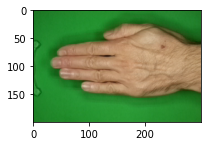

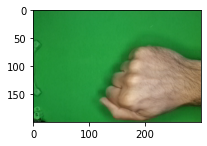

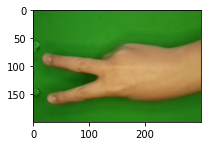

time: 627 ms


In [5]:
# Perintah untuk memvisualisasikan satu gambar dari dataset
# kertas
image = imread("datasets/rockpaperscissors/rps-cv-images/paper/0a3UtNzl5Ll3sq8K.png")
plt.figure(figsize=(3,3))
plt.imshow(image)
# batu
image = imread("datasets/rockpaperscissors/rps-cv-images/rock/00nKV8oHuTGi20gq.png")
plt.figure(figsize=(3,3))
plt.imshow(image)
# gunting
image = imread("datasets/rockpaperscissors/rps-cv-images/scissors/0CSaM2vL2cWX6Cay.png")
plt.figure(figsize=(3,3))
plt.imshow(image)

### Creating Object ImageDataGenerator & Data Augmentation

Membuat obyek gambar *dataset* dengan **ImageDataGenerator**, Autmentasi *dataset*, dan Membagi *dataset* validasi (*validation*) sebesar 20% dan *dataset* pelatihan (*training*) sebesar 80%.

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split = 0.2,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,    
    vertical_flip = True,
    fill_mode = "nearest")

time: 3.84 ms


### Using ImageDataGenerator Object

Menggunakan obyek **ImageDataGenerator** yang sudah dibuat

In [7]:
#Memuat dataset pelatihan & validasi
base_dir = os.path.join("datasets/rockpaperscissors/rps-cv-images")

img_size = 150
batch_size = 64

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    subset='training',
    class_mode= 'categorical')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size, 
    subset='validation',
    class_mode= 'categorical')

#Menampilkan bentuk dari masing-masing dataset
for image_batch, label_batch in train_generator:
  break
print("Bentuk array dari dataset train (pelatihan) adalah:", image_batch.shape,label_batch.shape)
for image_batch, label_batch in val_generator:
  break
print("Bentuk array dari dataset validation (validasi) adalah:", image_batch.shape,label_batch.shape)

Found 1751 images belonging to 3 classes.
Found 437 images belonging to 3 classes.
Bentuk array dari dataset train (pelatihan) adalah: (64, 150, 150, 3) (64, 3)
Bentuk array dari dataset validation (validasi) adalah: (64, 150, 150, 3) (64, 3)
time: 1.19 s


## Developing CNN Architecture (Creating Model)

Membuat arsitektur CNN mulai dari  Lapisan Masukkan (*Input Layer*), Lapisan Konvolusi (*Convolution Layer*), Lapisan aktivasi (*Activation Layer*), *Pooling Layer*, sampai Lapisan terhubung erat (*Fully Connected Layer/Densely Connected Layer*).

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(150, 150, 3), padding = "same"),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation="softmax")
])

time: 7.54 s


### Compiling Model

In [9]:
model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Training Model

Melatih model dari arsitektur CNN yang telah dibuat. Pada program ini dibuat sebanyak 75 epoch, namun jika *error/loss* pada *validation* sudah semakin kecil dan tidak adanya penurunan sebanyak 7 kali dan/atau di bawah 0,07 sebelum *epoch* ke 100 maka akan berhenti di *epoch* tersebut.

In [10]:
es = EarlyStopping(monitor = "val_loss", patience = 7, verbose = 1, min_delta = 0.07, mode = "auto")
history = model.fit(train_generator, 
                    epochs = 75, 
                    callbacks = [es],
                    validation_data = val_generator)

Epoch 1/75
28/28 [==============================] - 17s 620ms/step - loss: 1.0309 - acc: 0.4666 - val_loss: 0.8775 - val_acc: 0.6178
Epoch 2/75
28/28 [==============================] - 17s 612ms/step - loss: 0.8237 - acc: 0.6539 - val_loss: 0.7943 - val_acc: 0.6224
Epoch 3/75
28/28 [==============================] - 17s 620ms/step - loss: 0.6338 - acc: 0.7607 - val_loss: 0.6207 - val_acc: 0.7643
Epoch 4/75
28/28 [==============================] - 17s 612ms/step - loss: 0.5146 - acc: 0.7995 - val_loss: 0.4864 - val_acc: 0.8169
Epoch 5/75
28/28 [==============================] - 17s 616ms/step - loss: 0.4382 - acc: 0.8310 - val_loss: 0.4405 - val_acc: 0.8330
Epoch 6/75
28/28 [==============================] - 17s 618ms/step - loss: 0.4378 - acc: 0.8150 - val_loss: 0.3994 - val_acc: 0.8490
Epoch 7/75
28/28 [==============================] - 17s 618ms/step - loss: 0.3949 - acc: 0.8498 - val_loss: 0.4412 - val_acc: 0.8215
Epoch 8/75
28/28 [==============================] - 17s 613ms/step - 

### Visualization Performance of Training Model Result

Menampilkan grafik model hasil pelathiannya pada setiap *epoch*.

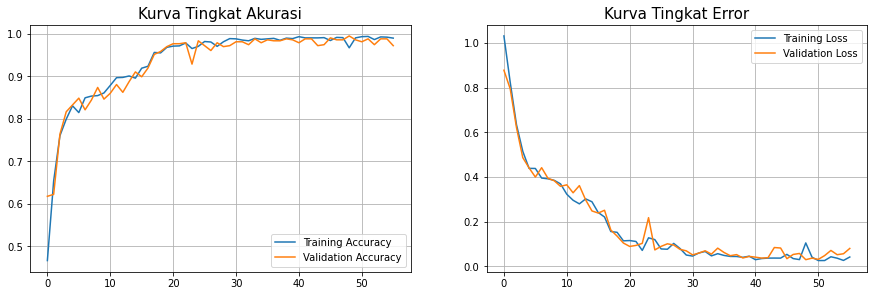

time: 427 ms


In [11]:
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)

plt.subplot(2, 2, 1)
plt.plot(history.history["acc"],label = "Training Accuracy")
plt.plot(history.history["val_acc"],label = "Validation Accuracy")
plt.legend()
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)

plt.subplot(2, 2, 2)
plt.plot(history.history["loss"],label = "Training Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

## Prediction from Image Files

Menguji hasil prediksi gambar yang diupload terhadap model hasil pelatihannya.

Saving Jatim.jpg to Jatim.jpg
Jatim.jpg
Bentuk array hasil prediksi: [[1. 0. 0.]]
Prediksi: paper


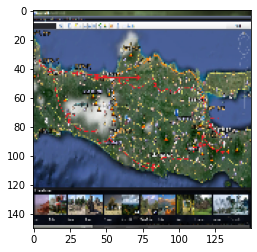

time: 1min 18s


In [31]:
import numpy as np
import matplotlib.image as mpimg
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.image import img_to_array, array_to_img

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  print("Bentuk array hasil prediksi:", classes)
  if classes[0][0]==1:
    print("Prediksi: paper")
  elif classes[0][1]==1:
    print("Prediksi: rock")
  else:
    print("Prediksi: scissors")